In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# load data

In [33]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True)

In [34]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True)

In [35]:
image, label = iter(train_loader).next()
image.__class__, label.__class__, image.size(), label.size()

(torch.FloatTensor,
 torch.LongTensor,
 torch.Size([256, 1, 28, 28]),
 torch.Size([256]))

## visualization

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
%matplotlib inline

In [37]:
make_grid(image[:5]).numpy().shape

(3, 32, 152)

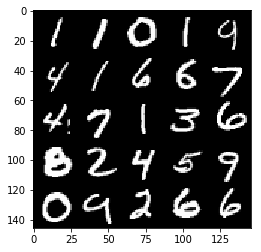

In [39]:
img = make_grid(image[:25], nrow=5, padding=1).numpy()
t = np.transpose(img, (1, 2, 0))
plt.imshow(t)

# train

In [40]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        # layerの定義
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [74]:
model = MultiLayerPerceptron(input_size=784, hidden_size=500, num_classes=10).cuda()
image = image.view(-1, 28 * 28)

# model()

In [75]:
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [76]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

def train(train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.view(-1, 28 * 28).cuda(), y.cuda()
        b_x = Variable(x)
        b_y = Variable(y)
        
        optimizer.zero_grad()
        output = model(b_x)
        loss = F.cross_entropy(output, b_y)
        train_loss += loss.data[0]
        loss.backward()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader)
    return train_loss

def valid(test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for x, y in test_loader:
        x, y = x.view(-1, 28 * 28).cuda(), y.cuda()
        b_x = Variable(x, volatile=True)
        b_y = Variable(y, volatile=True)
        
        outputs = model(b_x)
        test_loss += F.cross_entropy(outputs, b_y).data[0]
#         _, predicted = torch.max(outputs.data, 1)
#         correct += (predicted == b_y.data).sum()
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).cpu().sum()
        total += b_y.size(0)
        
    val_loss = test_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [77]:
loss_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(100):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)
    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 2.2818 val_loss: 2.2559 val_acc: 0.2559
epoch 1, loss: 2.2303 val_loss: 2.2036 val_acc: 0.4866
epoch 2, loss: 2.1786 val_loss: 2.1498 val_acc: 0.5947
epoch 3, loss: 2.1241 val_loss: 2.0938 val_acc: 0.6452
epoch 4, loss: 2.0654 val_loss: 2.0307 val_acc: 0.6757
epoch 5, loss: 2.0018 val_loss: 1.9619 val_acc: 0.6968
epoch 6, loss: 1.9326 val_loss: 1.8886 val_acc: 0.7146
epoch 7, loss: 1.8583 val_loss: 1.8136 val_acc: 0.7288
epoch 8, loss: 1.7797 val_loss: 1.7286 val_acc: 0.7419
epoch 9, loss: 1.6980 val_loss: 1.6418 val_acc: 0.7549
epoch 10, loss: 1.6150 val_loss: 1.5591 val_acc: 0.7649
epoch 11, loss: 1.5320 val_loss: 1.4742 val_acc: 0.7734
epoch 12, loss: 1.4512 val_loss: 1.3942 val_acc: 0.7823
epoch 13, loss: 1.3736 val_loss: 1.3205 val_acc: 0.7888
epoch 14, loss: 1.3002 val_loss: 1.2461 val_acc: 0.7947
epoch 15, loss: 1.2322 val_loss: 1.1834 val_acc: 0.8017
epoch 16, loss: 1.1691 val_loss: 1.1238 val_acc: 0.8077
epoch 17, loss: 1.1114 val_loss: 1.0589 val_acc: 0.8137
ep

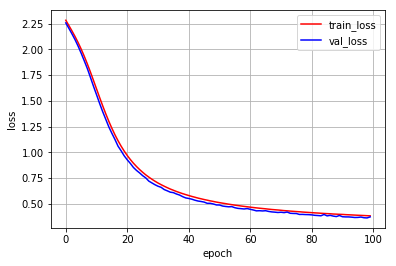

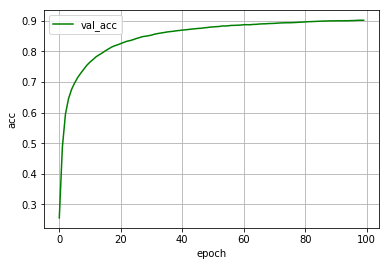

In [79]:
plt.figure()
plt.plot(range(100), loss_list, 'r-', label='train_loss')
plt.plot(range(100), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(100), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

In [113]:
a = Variable(iter(test_loader).next()[0].view(-1, 28 * 28).cuda())[0]
a

Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.

In [114]:
outputs = model(a)
outputs

Variable containing:
-2.5026
-4.6140
-0.2227
-3.6017
 7.5186
-0.7127
 2.4309
-0.8569
 0.8398
 1.6670
[torch.cuda.FloatTensor of size 10 (GPU 0)]

In [119]:
outputs.data
torch.max(outputs.data, -1)

(
  7.5186
 [torch.cuda.FloatTensor of size 1 (GPU 0)], 
  4
 [torch.cuda.LongTensor of size 1 (GPU 0)])

In [118]:
outputs.data.max(-1, keepdim=True)

(
  7.5186
 [torch.cuda.FloatTensor of size 1 (GPU 0)], 
  4
 [torch.cuda.LongTensor of size 1 (GPU 0)])